# Cover song detection

See [ELEN E4896 Music Signal Processing](https://www.ee.columbia.edu/~dpwe/e4896/practicals.html#prac11)

2016-04-13 Dan Ellis dpwe@ee.columbia.edu

In [25]:
%pylab inline
from __future__ import print_function

import cPickle as pickle
import enum
import os
import time
import IPython

import numpy as np
import scipy
import sklearn.metrics.pairwise

import librosa

Populating the interactive namespace from numpy and matplotlib


# Features
Features were calculated by downloading the set of 32kbps mp3s from
[covers80.tgz](http://labrosa.ee.columbia.edu/projects/coversongs/covers80/covers80.tgz)
then running the stand-alone Python feature extraction code in
[beat_sync_chroma.py](https://github.com/dpwe/elene4896/blob/master/prac11/beat_sync_chroma.py)
as below:
```python
python beat_sync_chroma.py -i coversongs/list1.txt -o coversongs/beatchromftrs -w coversongs/covers32k
python beat_sync_chroma.py -i coversongs/list2.txt -o coversongs/beatchromftrs -w coversongs/covers32k
```
which took 23 minutes. You can download the precomputed features along with the list files as
[coversongs-beatchromftrs.zip](https://www.ee.columbia.edu/~dpwe/e4896/code/prac11/coversongs-beatchromftrs.zip)

In [57]:
# Some helper functions.
def read_list_file(filename):
    """Read a text file with one item per line."""
    items = []
    with open(filename, 'r') as f:
        for line in f:
            items.append(line.strip())
    return items

def read_beat_chroma_labels(filename):
    """Read back a precomputed beat-synchronous chroma record."""
    with open(filename, "r") as f:
        beat_times, chroma_features, label_indices = pickle.load(f)
    return beat_times, chroma_features, label_indices

def chroma_rotate(chroma_features, semitones):
    """Shift the chroma bins up by semitones (down if negative)."""
    num_chroma = chroma_features.shape[-1]
    semitones = (semitones + num_chroma) % num_chroma
    column_permutation = np.hstack([np.arange(num_chroma - semitones, num_chroma), 
                                    np.arange(num_chroma - semitones)])
    return chroma_features[:, column_permutation]

def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)

In [27]:
# Where to find the data (on my machine).
DATA_DIR = '/Users/dpwe/Downloads/coversongs'
FEATURES_DIR = os.path.join(DATA_DIR, 'beatchromftrs')

def chroma_for_id(id_):
    """Return just the chroma array for a given ID."""
    _, chroma, _ = read_beat_chroma_labels(os.path.join(FEATURES_DIR, id_ + '.pkl'))
    return chroma

# We get the audio via the lab's web server.
url_base = 'http://labrosa.ee.columbia.edu:8013/'

In [28]:
# Read in the two lists of 80 cover songs.  Corresponding list elements are different versions of the same song.
ids_A = read_list_file(os.path.join(DATA_DIR, 'list1.txt'))
ids_B = read_list_file(os.path.join(DATA_DIR, 'list2.txt'))

In [40]:
# Inspect the index'th cover song pair.
index = 1
id_A = ids_A[index]
print(id_A)
IPython.display.Audio(url=url_base + id_A + '.mp3')

Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra


In [42]:
id_B = ids_B[index]
print(id_B)
IPython.display.Audio(url=url_base + id_B + '.mp3')

Abracadabra/sugar_ray+14_59+11-Abracadabra


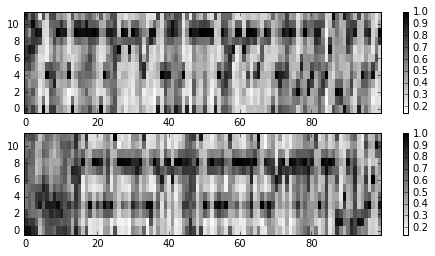

In [43]:
# Look at the first chunk of chroma features for each track.
ftrs_A = chroma_for_id(id_A)
ftrs_B = chroma_for_id(id_B)

plt.figure(figsize=(8,4))
subplot(211)
my_imshow(ftrs_A[:100].transpose())
colorbar()
subplot(212)
my_imshow(ftrs_B[:100].transpose())
colorbar()

# Cross-correlation comparison
The first approach to cover song detection is the "cross-correlation" described in the lecture. 
It boils down to calculating the inner product between the two chroma arrays for 
all beat offsets, and all chroma rotations, and looking for a large, sharp peak.

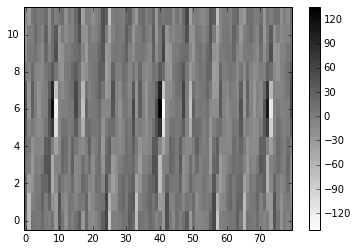

In [64]:
def correlation_similarity(ftrs_A, ftrs_B):
    xcorr = scipy.signal.convolve2d(scipy.signal.lfilter([1, -1], [1], ftrs_A, axis=0), 
                                    np.hstack([ftrs_B, ftrs_B])[::-1, ::-1], mode='same')
    return xcorr

xc = correlation_similarity(ftrs_A, ftrs_B)
peak_position = (np.argmax(np.max(xc, axis=1)), np.argmax(np.max(xc, axis=0)))
my_imshow(chroma_rotate(xc[peak_position[0] - 40: peak_position[0] + 40], 6 - peak_position[1]).transpose())
colorbar()
# The peak in the middle of the image shows the best correlation.

In [65]:
def calculate_track_distance_matrix(ids_A, ids_B, distance_function):
    """Pass all pairs of tracks to a distance function, return array."""
    scores = np.zeros((len(ids_A), len(ids_B)))
    for n_A, id_A in enumerate(ids_A):
        ftrs_A = chroma_for_id(id_A)
        print(time.ctime(), n_A, "of", len(ids_A), id_A)
        for n_B, id_B in enumerate(ids_B):
            scores[n_A, n_B] = distance_function(ftrs_A, chroma_for_id(id_B))
    return scores

def correlation_distance(ftrs_A, ftrs_B):
    """Return a single distance score for the pair of chroma arrays based on cross-correlation."""
    correlation_matrix = correlation_similarity(ftrs_A, ftrs_B)
    # Return the reciprocal of the peak correlation score, so most similar -> smallest "distance".
    return 1.0/np.max(correlation_matrix)

correlation_distances = calculate_track_distance_matrix(ids_A[:20], ids_B[:20], correlation_distance)

Tue Apr 12 23:36:20 2016 0 of 20 A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale
Tue Apr 12 23:36:39 2016 1 of 20 Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra
Tue Apr 12 23:36:51 2016 2 of 20 Addicted_To_Love/robert_palmer+Riptide+03-Addicted_To_Love
Tue Apr 12 23:36:58 2016 3 of 20 All_Along_The_Watchtower/bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower
Tue Apr 12 23:37:09 2016 4 of 20 All_Tomorrow_s_Parties/japan+Quiet_Life+06-All_Tomorrow_s_Parties
Tue Apr 12 23:37:26 2016 5 of 20 America/paul_simon+Concert_in_the_Park_Disc_2+09-America
Tue Apr 12 23:37:32 2016 6 of 20 Before_You_Accuse_Me/creedence_clearwater_revival+Cosmo_s_Factory+02-Before_You_Accuse_Me
Tue Apr 12 23:37:36 2016 7 of 20 Between_The_Bars/elliott_smith+Either_Or+04-Between_The_Bars
Tue Apr 12 23:37:39 2016 8 of 20 Blue_Collar_Man/reo_speedwagon+Arch_Allies_Disc_1+01-Blue_Collar_Man
Tue Apr 12 23:37:54 2016 9 of 20 Caroline_No/beach_boys+Pet_Sounds+13-Car

Accuracy= 0.45


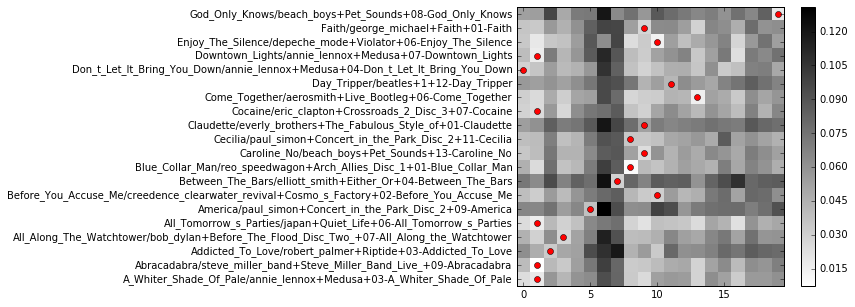

In [75]:
def score_track_distance_matrix(track_distance_matrix, ids_A=None):
    """Score the results of a cover song run, and plot the confusion matrix."""
    plt.figure(figsize=(6,5))
    my_imshow(track_distance_matrix)
    colorbar()
    # Find the index of the smallest distance (best match) in each row.
    per_row_match_index = np.argmin(track_distance_matrix, axis=1)
    num_items = track_distance_matrix.shape[0]
    plot(per_row_match_index, np.arange(num_items), 'or')
    xlim([-0.5, num_items - 0.5])
    ylim([-0.5, num_items - 0.5])
    if ids_A is not None:
        yticks(np.arange(num_items), ids_A)
    # What proportion are the known true answer (where the best match column matches the row)?
    accuracy = np.mean(per_row_match_index == np.arange(len(per_row_match_index)))
    return accuracy

print("Accuracy=", score_track_distance_matrix(correlation_distances, ids_A[:20]))

# DTW Path comparison
Cross-correlation can work well, but it's quite computationally intense, and it relies on the 
metrical levels matching.  DTW can follow differences in local timing, and can be 
computationally cheaper.

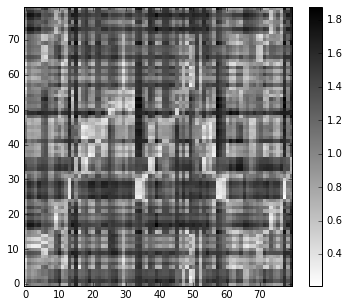

In [76]:
# Make an "all pairs" distance matrix.
index = 0
local_costs = sklearn.metrics.pairwise.pairwise_distances(chroma_for_id(ids_A[index]), 
                                                          chroma_for_id(ids_B[index]))
plt.figure(figsize=(6,5))
my_imshow(local_costs[:80, :80])
colorbar()

In [18]:
# Define the core DTW calculation.
import numba

DIAGONAL = 0
HORIZONTAL = 1
VERTICAL = 2

@numba.jit(nopython=True)
def dtw_core(dist_mat, penalty, traceback):
    """Core dynamic programming routine for DTW.
    `dist_mat` and `traceback` will be modified in-place.

    Args:
      dist_mat : np.ndarray
        Distance matrix to update with lowest-cost path to each entry.
      penalty : int or float
        Additive penalty for non-diagonal moves.
      traceback : np.ndarray
        Matrix to populate with the lowest-cost traceback from each entry.
    """
    # At each iteration, we are computing lowest cost to D[row, col].
    for row in xrange(1, dist_mat.shape[0]):
        dist_mat[row, 0] += dist_mat[row - 1, 0] + add_pen
        traceback[row, 0] = VERTICAL
    for col in xrange(1, dist_mat.shape[1]):
        dist_mat[0, col] += dist_mat[0, col - 1] + add_pen
        traceback[0, col] = HORIZONTAL
    for col in xrange(1, dist_mat.shape[1]):
        for row in xrange(1, dist_mat.shape[0]):
            diag_cost = dist_mat[row - 1, col - 1]
            vert_cost = dist_mat[row - 1, col] + add_pen
            horiz_cost = dist_mat[row, col - 1] + add_pen
            # Diagonal move (which has no penalty) is lowest
            if diag_cost <= horiz_cost and diag_cost <= vert_cost:
                traceback[row, col] = DIAGONAL
                dist_mat[row, col] += diag_cost
            # Horizontal move (has penalty)
            elif horiz_cost <= vert_cost:
                traceback[row, col] = HORIZONTAL
                dist_mat[row, col] += horiz_cost
            # Vertical move (has penalty)
            else:
                traceback[row, col] = VERTICAL
                dist_mat[row, col] += vert_cost

def find_traceback(traceback_matrix, ending_row, ending_col, local_costs_matrix=None):
    """Decode the traceback matrix from the given ending point to a full path."""
    row = ending_row
    col = ending_col
    path = [(row, col)]
    path_costs = []
    if local_costs_matrix is not None:
        path_costs.append(local_costs_matrix[row, col])
    while row > 0 or col > 0:
        predecessor = traceback_matrix[row, col]
        if predecessor == HORIZONTAL:
            col = col - 1
        elif predecessor == VERTICAL:
            row = row - 1
        else:
            col = col - 1
            row = row - 1
        path.append((row, col))
        if local_costs_matrix is not None:
            path_costs.append(local_costs_matrix[row, col])
    return np.array(path[::-1]), np.array(path_costs[::-1])

def dtw(local_costs, penalty=0.2):
    """Perform DTW over a local_costs matrix and return path, best cost, and path costs."""
    distance_matrix = np.copy(local_costs)
    traceback = np.empty(distance_matrix.shape, np.uint8)
    dtw_core(distance_matrix, penalty, traceback)
    path, path_costs = find_traceback(traceback, distance_matrix.shape[0] - 1, distance_matrix.shape[1] - 1, 
                                      local_costs + penalty*(traceback != DIAGONAL))
    return path, distance_matrix[-1, -1], path_costs

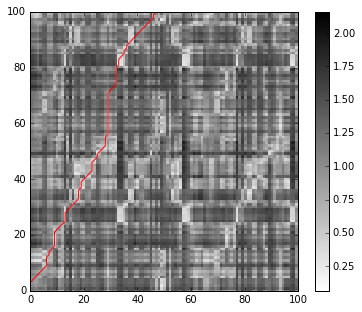

In [77]:
# Calculate DTW through the local_costs matrix and plot the path atop the local costs.
path, best_cost, path_costs = dtw(local_costs)

limit = 100
plt.figure(figsize=(6,5))
my_imshow(local_costs)
colorbar()
plot(path[:, 1], path[:, 0], '-r')
if limit:
    ylim([0, limit])
    xlim([0, limit])

1187.97079318
0.791586138025
0.763687419932


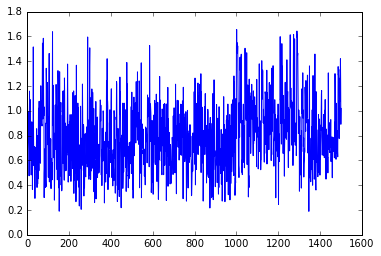

In [78]:
# Looking at the per-step costs down the best path give some measure of match quality.
plot(path_costs)
print(np.mean(path_costs))
print(np.median(path_costs))

In [83]:
# Calculate distances over test set using median path cost.
def dtw_distance(ftrs_A, ftrs_B):
    """Return a cover song match score as the best cost of locally-normalized local costs."""
    local_costs = sklearn.metrics.pairwise.pairwise_distances(ftrs_A, ftrs_B)
    path, total_costs, path_cost = dtw(local_costs, penalty=0.2)
    return np.median(path_cost)

dtw_distances = calculate_track_distance_matrix(ids_A[:20], ids_B[:20], dtw_distance)

Wed Apr 13 00:01:20 2016 0 of 20 A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale
Wed Apr 13 00:01:21 2016 1 of 20 Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra
Wed Apr 13 00:01:21 2016 2 of 20 Addicted_To_Love/robert_palmer+Riptide+03-Addicted_To_Love
Wed Apr 13 00:01:22 2016 3 of 20 All_Along_The_Watchtower/bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower
Wed Apr 13 00:01:22 2016 4 of 20 All_Tomorrow_s_Parties/japan+Quiet_Life+06-All_Tomorrow_s_Parties
Wed Apr 13 00:01:23 2016 5 of 20 America/paul_simon+Concert_in_the_Park_Disc_2+09-America
Wed Apr 13 00:01:23 2016 6 of 20 Before_You_Accuse_Me/creedence_clearwater_revival+Cosmo_s_Factory+02-Before_You_Accuse_Me
Wed Apr 13 00:01:24 2016 7 of 20 Between_The_Bars/elliott_smith+Either_Or+04-Between_The_Bars
Wed Apr 13 00:01:24 2016 8 of 20 Blue_Collar_Man/reo_speedwagon+Arch_Allies_Disc_1+01-Blue_Collar_Man
Wed Apr 13 00:01:24 2016 9 of 20 Caroline_No/beach_boys+Pet_Sounds+13-Car

Accuracy= 0.4


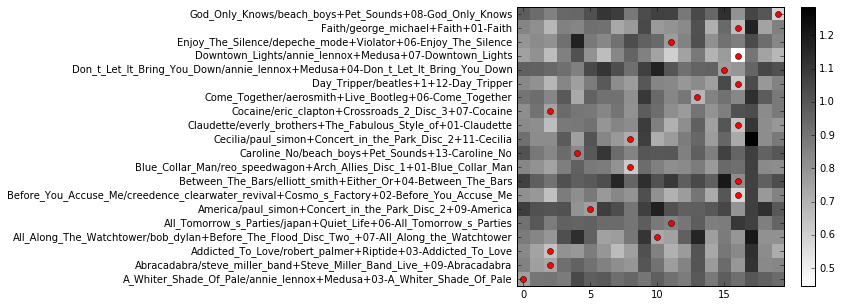

In [84]:
print("Accuracy=", score_track_distance_matrix(dtw_distances, ids_A[:20]))

# Chroma-rotation features DTW

The third approach follows Serra & Gomez 2008 by replacing each local cost value
with a binary score saying whether the rotation that gives the best correlation
between the two chroma vectors matches the global most popular chroma rotation.

In [89]:
def best_chroma_rotations(chroma_A, chroma_B):
    """Return a (chroma_A.shape[0], chroma_B.shape[1]) array of chroma rotations giving per-cell greatest correlation."""
    num_frames_A, num_chroma = chroma_A.shape
    num_frames_B, num_chroma_B = chroma_B.shape
    rotated_chroma_B = np.copy(chroma_B)
    assert num_chroma == num_chroma_B
    similarities = np.zeros((num_chroma, num_frames_A, num_frames_B))
    rotate_chroma_indices = np.hstack([np.arange(1, num_chroma), 0])
    for i in xrange(num_chroma):
        similarities[i] = sklearn.metrics.pairwise.pairwise_distances(chroma_A, rotated_chroma_B, metric='cosine')
        # Rotate chroma of B.
        rotated_chroma_B = rotated_chroma_B[:, rotate_chroma_indices]
    return np.argmin(similarities, axis=0)

def chromarot_dtw_alignment(ftrs_A, ftrs_B):
    """Perform alignment with chroma-rotation features."""
    chroma_rotations = best_chroma_rotations(ftrs_A, ftrs_B)
    # Find the most popular rotation.
    rotation_counts = np.bincount(chroma_rotations.flatten())
    best_rotation = np.argmax(rotation_counts)
    #print("Best rotation=", best_rotation)
    rotation_distance = (chroma_rotations != best_rotation).astype(float)
    # Calculate DTW cost through the binarized matrix.
    path, best_cost, path_cost = dtw(rotation_distance, penalty=0.2)
    return rotation_distance, path, path_cost

def chromarot_dtw_distance(ftrs_A, ftrs_B):
    """Compare two candidate covers using chroma rotation DTW."""
    _, _, path_cost = chromarot_dtw_alignment(ftrs_A, ftrs_B)
    # Return mean of per-step cost as overall match quality metric.
    return np.mean(path_cost)

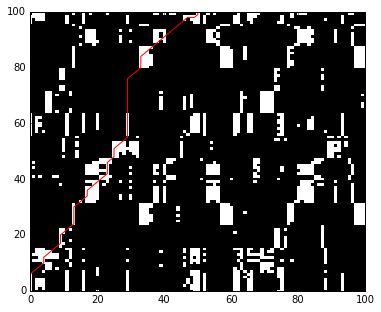

In [95]:
# Example of chromarot alignment.
index = 0
rotation_distance, path, path_cost = chromarot_dtw_alignment(
    chroma_for_id(ids_A[index]), chroma_for_id(ids_B[index]))

limit = 100
plt.figure(figsize=(6,5))
my_imshow(rotation_distance)
plot(path[:, 1], path[:, 0], '-r')
if limit:
    ylim([0, limit])
    xlim([0, limit])

Wed Apr 13 00:16:16 2016 0 of 20 A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale
Wed Apr 13 00:16:21 2016 1 of 20 Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra
Wed Apr 13 00:16:24 2016 2 of 20 Addicted_To_Love/robert_palmer+Riptide+03-Addicted_To_Love
Wed Apr 13 00:16:26 2016 3 of 20 All_Along_The_Watchtower/bob_dylan+Before_The_Flood_Disc_Two_+07-All_Along_the_Watchtower
Wed Apr 13 00:16:29 2016 4 of 20 All_Tomorrow_s_Parties/japan+Quiet_Life+06-All_Tomorrow_s_Parties
Wed Apr 13 00:16:34 2016 5 of 20 America/paul_simon+Concert_in_the_Park_Disc_2+09-America
Wed Apr 13 00:16:36 2016 6 of 20 Before_You_Accuse_Me/creedence_clearwater_revival+Cosmo_s_Factory+02-Before_You_Accuse_Me
Wed Apr 13 00:16:38 2016 7 of 20 Between_The_Bars/elliott_smith+Either_Or+04-Between_The_Bars
Wed Apr 13 00:16:39 2016 8 of 20 Blue_Collar_Man/reo_speedwagon+Arch_Allies_Disc_1+01-Blue_Collar_Man
Wed Apr 13 00:16:43 2016 9 of 20 Caroline_No/beach_boys+Pet_Sounds+13-Car

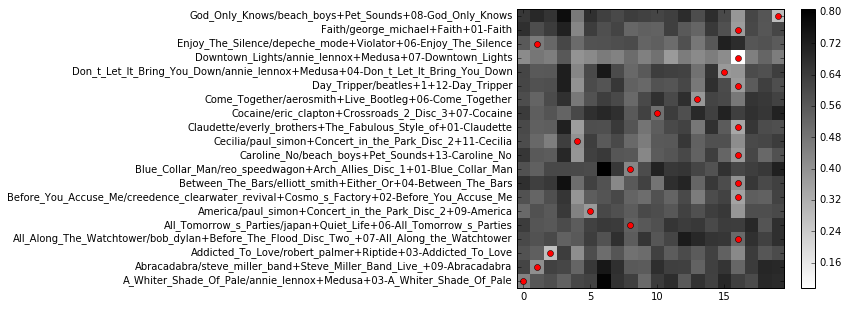

In [93]:
rot_distances = calculate_track_distance_matrix(ids_A[:20], ids_B[:20], chromarot_dtw_distance)
print("Accuracy=", score_track_distance_matrix(rot_distances, ids_A[:20]))